# Define a model for SER

In [43]:
import tensorflow as tf
import tensorflow.keras
from tensorflow.keras.models import Sequential 
from tensorflow.keras.callbacks import EarlyStopping 
from tensorflow.keras.layers import Conv2D, Flatten, Dense, Dropout, MaxPooling2D, LSTM, TimeDistributed, InputLayer, Reshape, BatchNormalization

In [52]:
model = Sequential([
    InputLayer(input_shape=(256,256,3)),
    Reshape((8,32,256,3)),
    TimeDistributed(Conv2D(16, kernel_size=(3,3), activation='relu', strides=(1))),
    TimeDistributed(BatchNormalization()),
    TimeDistributed(MaxPooling2D(pool_size=(2,2))),
    TimeDistributed(Conv2D(32, kernel_size=(3,3), activation='relu', strides=(1))),
    TimeDistributed(MaxPooling2D(pool_size=(2,2), strides=(2))),
    TimeDistributed(Conv2D(64, kernel_size=(3,3), activation='relu', strides=(1))),
    TimeDistributed(MaxPooling2D(pool_size=(2,2), strides=(2))),
 
    TimeDistributed(Flatten()),
    Dropout(0.2),
    LSTM(128, return_sequences=True),
    Flatten(),
    Dense(7, activation='softmax')
])

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=5, mode='auto', restore_best_weights=True)

model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_8 (Reshape)          (None, 8, 32, 256, 3)     0         
_________________________________________________________________
time_distributed_44 (TimeDis (None, 8, 30, 254, 16)    448       
_________________________________________________________________
time_distributed_45 (TimeDis (None, 8, 30, 254, 16)    64        
_________________________________________________________________
time_distributed_46 (TimeDis (None, 8, 15, 127, 16)    0         
_________________________________________________________________
time_distributed_47 (TimeDis (None, 8, 13, 125, 32)    4640      
_________________________________________________________________
time_distributed_48 (TimeDis (None, 8, 6, 62, 32)      0         
_________________________________________________________________
time_distributed_49 (TimeDis (None, 8, 4, 60, 64)     

# EmoDB

Import data for train/test

In [12]:
import numpy as np
x_train = np.load('/datasets/nicolas_facchinetti/processed_data/EmoDB/first_experiment/x_im_train.npy')
x_test = np.load('/datasets/nicolas_facchinetti/processed_data/EmoDB/first_experiment/x_im_test.npy')
y_train = np.load('/datasets/nicolas_facchinetti/processed_data/EmoDB/first_experiment/y_im_train.npy')
y_test = np.load('/datasets/nicolas_facchinetti/processed_data/EmoDB/first_experiment/y_im_test.npy')

In [58]:
history = model.fit(x_train, y_train, batch_size=32, epochs=50, validation_data=(x_test, y_test), callbacks=[early_stopping])

Epoch 1/50
15/15 [==============================] - 1s 35ms/step - loss: 0.0348 - accuracy: 1.0000 - val_loss: 1.6816 - val_accuracy: 0.3894
Epoch 2/50
15/15 [==============================] - 0s 29ms/step - loss: 0.0228 - accuracy: 1.0000 - val_loss: 1.5614 - val_accuracy: 0.4336
Epoch 3/50
15/15 [==============================] - 0s 31ms/step - loss: 0.0151 - accuracy: 1.0000 - val_loss: 1.5647 - val_accuracy: 0.4336
Epoch 4/50
15/15 [==============================] - 0s 31ms/step - loss: 0.0106 - accuracy: 1.0000 - val_loss: 1.5104 - val_accuracy: 0.4956
Epoch 5/50
15/15 [==============================] - 0s 31ms/step - loss: 0.0085 - accuracy: 1.0000 - val_loss: 1.5120 - val_accuracy: 0.4690
Epoch 6/50
15/15 [==============================] - 0s 30ms/step - loss: 0.0075 - accuracy: 1.0000 - val_loss: 1.4263 - val_accuracy: 0.5221
Epoch 7/50
15/15 [==============================] - 0s 30ms/step - loss: 0.0060 - accuracy: 1.0000 - val_loss: 1.4119 - val_accuracy: 0.5044
Epoch 8/50
15

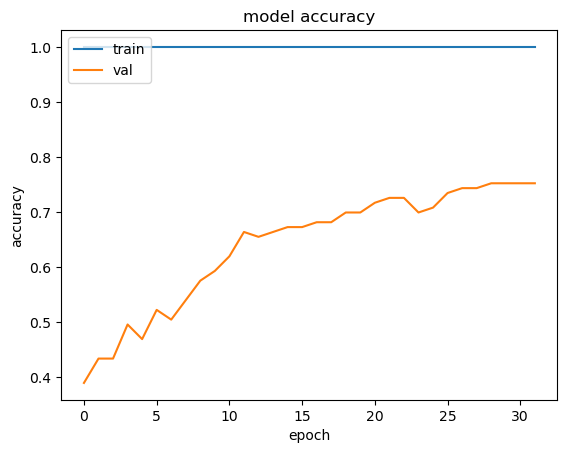

In [59]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

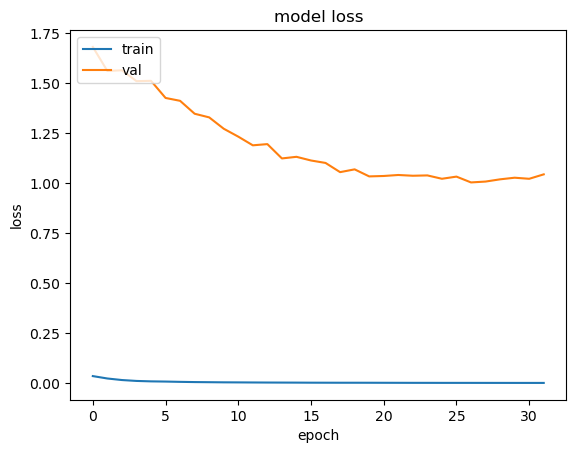

In [60]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [62]:
_, accuracy_test_original = model.evaluate(x_test, y_test)
print('Accuracy on original test data: {:4.2f}%'.format(accuracy_test_original * 100))

4/4 [==============================] - 0s 9ms/step - loss: 1.0037 - accuracy: 0.7434
Accuracy on original test data: 74.34%


Save the model for future computations

In [63]:
model.save('trained_models/EMODB_CNN_LSTM2.h5')

# EMOVO

Import data for train/test

In [64]:
import numpy as np
x_train = np.load('/datasets/nicolas_facchinetti/processed_data/EMOVO/first_experiment/x_im_train.npy')
x_test = np.load('/datasets/nicolas_facchinetti/processed_data/EMOVO/first_experiment/x_im_test.npy')
y_train = np.load('/datasets/nicolas_facchinetti/processed_data/EMOVO/first_experiment/y_im_train.npy')
y_test = np.load('/datasets/nicolas_facchinetti/processed_data/EMOVO/first_experiment/y_im_test.npy')

In [65]:
history = model.fit(x_train, y_train, batch_size=32, epochs=50, validation_data=(x_test, y_test), callbacks=[early_stopping])

Epoch 1/50
16/16 [==============================] - 1s 49ms/step - loss: 2.3067 - accuracy: 0.1535 - val_loss: 2.0085 - val_accuracy: 0.1102
Epoch 2/50
16/16 [==============================] - 0s 30ms/step - loss: 1.9246 - accuracy: 0.2028 - val_loss: 1.9457 - val_accuracy: 0.1732
Epoch 3/50
16/16 [==============================] - 1s 32ms/step - loss: 1.8865 - accuracy: 0.2047 - val_loss: 1.9693 - val_accuracy: 0.1339
Epoch 4/50
16/16 [==============================] - 1s 32ms/step - loss: 1.8352 - accuracy: 0.2559 - val_loss: 1.8622 - val_accuracy: 0.2520
Epoch 5/50
16/16 [==============================] - 0s 32ms/step - loss: 1.7750 - accuracy: 0.2697 - val_loss: 1.8153 - val_accuracy: 0.2441
Epoch 6/50
16/16 [==============================] - 1s 33ms/step - loss: 1.6962 - accuracy: 0.3406 - val_loss: 1.7923 - val_accuracy: 0.3150
Epoch 7/50
16/16 [==============================] - 1s 33ms/step - loss: 1.6468 - accuracy: 0.3799 - val_loss: 1.7516 - val_accuracy: 0.3307
Epoch 8/50
16

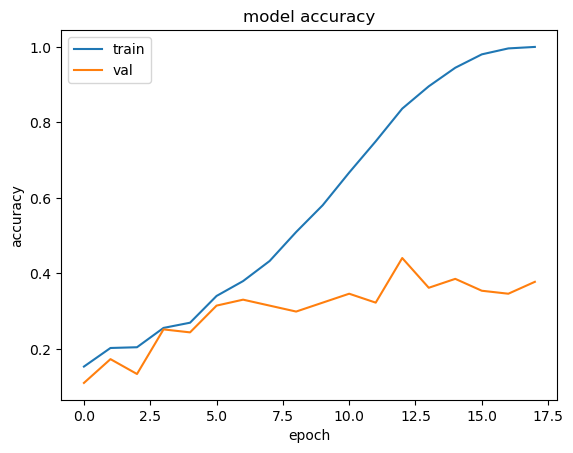

In [66]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

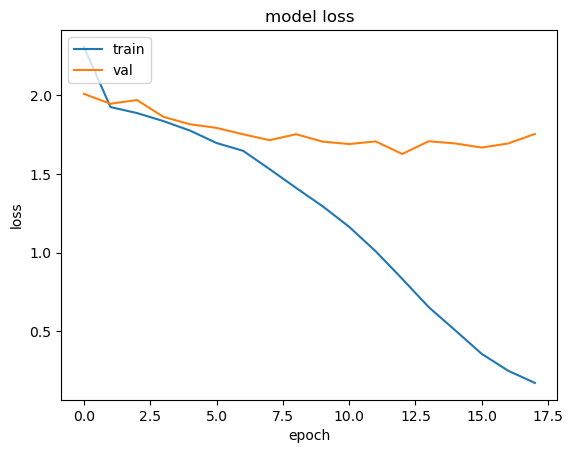

In [67]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [68]:
_, accuracy_test_original = model.evaluate(x_test, y_test)
print('Accuracy on original test data: {:4.2f}%'.format(accuracy_test_original * 100))

4/4 [==============================] - 0s 9ms/step - loss: 1.6266 - accuracy: 0.4409
Accuracy on original test data: 44.09%


Save the model for future computations

In [69]:
model.save('trained_models/EMOVO_CNN_LSTM2.h5')